# CNN on CIFAR-100

Author : **Tanguy Hardion**

## Introduction

### Objective

The objective of this project is to train a model to classify images. We will create and train the model from scratch using an image dataset that we will preprocess.

### Method

We will use supervised **deep learning** and create a **convolutional neural network** (CNN) to train our model. We will use the `tensorflow` library.

### Dataset

There are many labeled image datasets. For this project, I have chosen the **CIFAR-100** dataset. It consists of 60,000 color images of 32x32 pixels, labeled in two ways:

- **Coarse labels**: 20 classes (broad categories)
- **Fine labels**: 100 classes (subcategories)

For this project, we will use the **fine labels** because they allow for more precise classification, making for a more interesting deep learning exercise.

CIFAR-100 is divided into 50,000 training images and 10,000 test images. The dataset is available on [HuggingFace](https://huggingface.co/datasets/uoft-cs/cifar100), and that's where we'll retrieve it from. All labels are integers, and the class names are available on HuggingFace or later in this notebook (in the variable `fine_labels_dict`, used during testing).

### Project Content

- This `.ipynb` notebook containing the outputs of the code cells from my last execution for clarity
- A `requirements.txt` file specifying the necessary packages
- A `cifar100_model.keras` file containing the trained model (if you don't want to train it yourself)

## Notes

### Versions

Python version used: `3.11.9`. Issues may arise with TensorFlow in version `3.12`.

TensorFlow version used: `2.16.1`. Note that if you don't use this TensorFlow version, the provided model might not load.

All necessary packages are listed in the `requirements.txt` file. To install them, you can use the following command:

```bash
pip install -r requirements.txt
```

### Training

Training can take a while, depending on your machine's processing power. To speed up the process, you can reduce the number of epochs or use a more powerful processor, or a GPU. Google Colab provides powerful GPUs for free, suitable for this kind of task.

## Library Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random

c:\Users\tangu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset from HuggingFace

In [2]:
# Train split : 50 000 images
train_dataset = load_dataset("cifar100", split="train")

# Test split : 10 000 images
test_dataset = load_dataset("cifar100", split="test")

## Initialization of useful variables

In [3]:
# Number of classes ("fine_label"): 100
num_classes = len(train_dataset.features["fine_label"].names)
print(f"Number of classes: {num_classes}")

# Image size: 32x32 pixels with 3 color channels (RGB)
image_shape = np.array(train_dataset[0]["img"]).shape
print(f"Image size: {image_shape}")

Number of classes: 100
Image size: (32, 32, 3)


In [4]:
# Labels dictionary (copied from the dataset documentation)
fine_labels_dict = {
    0: "apple",
    1: "aquarium_fish",
    2: "baby",
    3: "bear",
    4: "beaver",
    5: "bed",
    6: "bee",
    7: "beetle",
    8: "bicycle",
    9: "bottle",
    10: "bowl",
    11: "boy",
    12: "bridge",
    13: "bus",
    14: "butterfly",
    15: "camel",
    16: "can",
    17: "castle",
    18: "caterpillar",
    19: "cattle",
    20: "chair",
    21: "chimpanzee",
    22: "clock",
    23: "cloud",
    24: "cockroach",
    25: "couch",
    26: "cra",
    27: "crocodile",
    28: "cup",
    29: "dinosaur",
    30: "dolphin",
    31: "elephant",
    32: "flatfish",
    33: "forest",
    34: "fox",
    35: "girl",
    36: "hamster",
    37: "house",
    38: "kangaroo",
    39: "keyboard",
    40: "lamp",
    41: "lawn_mower",
    42: "leopard",
    43: "lion",
    44: "lizard",
    45: "lobster",
    46: "man",
    47: "maple_tree",
    48: "motorcycle",
    49: "mountain",
    50: "mouse",
    51: "mushroom",
    52: "oak_tree",
    53: "orange",
    54: "orchid",
    55: "otter",
    56: "palm_tree",
    57: "pear",
    58: "pickup_truck",
    59: "pine_tree",
    60: "plain",
    61: "plate",
    62: "poppy",
    63: "porcupine",
    64: "possum",
    65: "rabbit",
    66: "raccoon",
    67: "ray",
    68: "road",
    69: "rocket",
    70: "rose",
    71: "sea",
    72: "seal",
    73: "shark",
    74: "shrew",
    75: "skunk",
    76: "skyscraper",
    77: "snail",
    78: "snake",
    79: "spider",
    80: "squirrel",
    81: "streetcar",
    82: "sunflower",
    83: "sweet_pepper",
    84: "table",
    85: "tank",
    86: "telephone",
    87: "television",
    88: "tiger",
    89: "tractor",
    90: "train",
    91: "trout",
    92: "tulip",
    93: "turtle",
    94: "wardrobe",
    95: "whale",
    96: "willow_tree",
    97: "wolf",
    98: "woman",
    99: "worm",
}

## Quick dataset exploration

In [5]:
print("Dataset shape: ", train_dataset.shape)

Dataset shape:  (50000, 3)


### Displaying some random images with their labels

As the images are 32x32 pixels, they are quite small, explaining the low resolution in the images below. However, this will be enough to train our deep learning model.

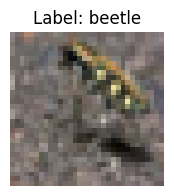

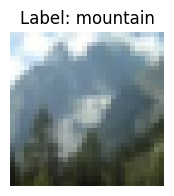

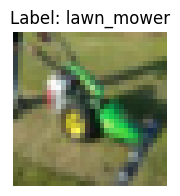

In [6]:
for i in range(3):
    random_index = random.randint(0, len(train_dataset))
    random_image = train_dataset[random_index]["img"]
    random_label = train_dataset[random_index]["fine_label"]
    plt.figure(figsize=(2, 2))
    plt.title(f"Label: {fine_labels_dict[random_label]}")
    plt.axis("off")
    plt.imshow(random_image)

## Image preprocessing

We will now preprocess the images to make them usable by our deep learning model. The images are already normalized (pixel values between 0 and 1), but we will:

- Convert them to `tf.float32` to use with TensorFlow
- Resize them to ensure they are 32x32 pixels

### Preprocessing function

In [7]:
def preprocess_image(image, label):
    """
    Preprocesses images.
    Converts the image to tf.float32 and resizes it to 32x32 pixels.
    """

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [32, 32])
    return image, label

### Data generator function

In Python, a generator is a function that loads data into memory as needed during training, preventing memory overload and enabling the training of models on large datasets.

In [8]:
def generator(dataset):
    """
    Generates images and labels.
    From the given dataset, returns a tuple (image, label).

    If the image is in 2D (grayscale), it is duplicated across 3 channels to ensure all images have the same shape.
    """

    for element in dataset:
        # Retrieve image and label
        image = np.array(element["img"])
        label = element["fine_label"]

        # Duplicate 2D images across 3 channels
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)

        yield image, label

### Creating TensorFlow datasets

TensorFlow uses `tf.data.Dataset` objects to handle data. We will create these objects for training and testing using the functions we just defined.

In [9]:
# Training dataset
train_dataset_tf = tf.data.Dataset.from_generator(
    lambda: generator(train_dataset),

    # Output signature: tuple (image, label)
    output_signature=(
        tf.TensorSpec(shape=image_shape, dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    ),
)

# Testing dataset
test_dataset_tf = tf.data.Dataset.from_generator(
    lambda: generator(test_dataset),

    # Output signature: tuple (image, label)
    output_signature=(
        tf.TensorSpec(shape=image_shape, dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    ),
)

### Appyling preprocessing functions to the datasets

We're now going to apply the preprocessing to our TensorFlow datasets. Below, we will:

- Apply the `preprocess_image` function to each image in the dataset

- Create batches of 32 images for training. A batch is a set of images that will be processed at the same time by the model.

- Preload the images to speed up the process (`prefetch`), letting TensorFlow dynamically adjust the number of images (`tf.data.AUTOTUNE`)

- Repeat the images so they are used multiple times during training (`repeat`, in this case `2` times). This increases the number of images (batches) per epoch. We could also simply increase the number of epochs, but increasing the dataset size will give us faster training (since fewer epochs = fewer validation steps).

Shuffling (`shuffle`) is not necessary here, as CIFAR-100 is already shuffled.

In [10]:
# Setting batch size at 32 (a common value)
batch_size = 32

train_dataset_tf_preprocessed = (
    train_dataset_tf.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat(2)
)

test_dataset_tf_preprocessed = (
    test_dataset_tf.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

## Model creation

### Neural Network Architecture

We will now create our deep learning model. We will use a Convolutional Neural Network (CNN) to process the images. A CNN is a type of neural network that is very effective for handling spatial data, such as images.

We will detail the structure directly in the code.

In [11]:
def create_cnn(input_shape, n_classes):
    """
    Creates a simple convolutional neural network model
    based on an input of shape `input_shape` and `n_classes` output classes.
    """

    # Input layer of shape `input_shape`
    inputs = Input(shape=input_shape)

    # First convolution block
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)  # 32 filters of size 3x3
    x = BatchNormalization()(x)  # Normalization of the previous layer's activations (to speed up learning)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Reduces image size by a factor of 2 (to make the model more efficient)
    x = Dropout(0.2)(x)  # Randomly disables 20% of neurons (regularization, to avoid overfitting)

    # Second convolution block (same as the first, but with more filters and a higher dropout)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Third convolution block (same as the second, but with even more filters and an even higher dropout)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Output layer
    x = Flatten()(x)  # Converts the 3D output to a 1D vector
    x = Dense(512, activation="relu")(x)  # Dense layer with 512 neurons, using ReLU activation function
    x = Dropout(0.5)(x)  # 50% dropout (to avoid overfitting)
    outputs = Dense(n_classes, activation="softmax")(x)  # Output layer with softmax activation function

    model = Model(inputs, outputs)
    return model

### Creation and compilation of the model

In [12]:
model = create_cnn(image_shape, num_classes)

In [13]:
model.compile(
    # Adam gradient descent algorithm, with a default learning rate (0.001)
    optimizer=Adam(),
    # Loss function for a multi-class classification problem
    loss=SparseCategoricalCrossentropy(),
    # To measure model accuracy during training
    metrics=[SparseCategoricalAccuracy()],
)

We can now display a summary of the model to see its structure.

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             

 Total params: 1,389,188 (5.30 MB)

 Trainable params: 1,388,292 (5.30 MB)

 Non-trainable params: 896 (3.50 KB)

## Model training

### Execution

Our model is now ready to be trained. We will start the training with the `fit` function and store the results in the object `r`, which will contain the training results.

#### Epochs

We're using 10 epochs for training here (~1h with an i5 9th Gen), but you can increase or decrease this number based on your machine's performance. Ideally, we would want a higher number of epochs for better training, but without Colab or a GPU, it can take a long time.

Knowing that 5 epochs are enough to get about **40%** accuracy, if you want to train the model yourself, I suggest reducing the number of epochs to 5, which will already give you a good idea of the model's performance.

No worries, if you don't like waiting, you can skip directly to the next part to load and test the pre-trained model provided in the `model` folder.

#### Validation

At the end of each epoch, the model is tested with validation data (the test dataset) to monitor its progress over the epochs. Our model will not be trained on `test_dataset_tf_preprocessed`, naturally, allowing us to reuse this split for testing.

In [15]:
r = model.fit(
    x=train_dataset_tf_preprocessed,
    validation_data=test_dataset_tf_preprocessed,
    epochs=10
)

Epoch 1/10
   3126/Unknown 354s 112ms/step - loss: 4.4287 - sparse_categorical_accuracy: 0.0488

c:\Users\tangu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3126/3126 ━━━━━━━━━━━━━━━━━━━━ 364s 115ms/step - loss: 4.4286 - sparse_categorical_accuracy: 0.0488 - val_loss: 3.5406 - val_sparse_categorical_accuracy: 0.1624
Epoch 2/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 356s 114ms/step - loss: 3.6651 - sparse_categorical_accuracy: 0.1304 - val_loss: 2.9048 - val_sparse_categorical_accuracy: 0.2839
Epoch 3/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 355s 114ms/step - loss: 3.1528 - sparse_categorical_accuracy: 0.2187 - val_loss: 2.4982 - val_sparse_categorical_accuracy: 0.3476
Epoch 4/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 357s 114ms/step - loss: 2.6832 - sparse_categorical_accuracy: 0.3092 - val_loss: 2.2414 - val_sparse_categorical_accuracy: 0.4022
Epoch 5/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 318s 102ms/step - loss: 2.3015 - sparse_categorical_accuracy: 0.3885 - val_loss: 2.0250 - val_sparse_categorical_accuracy: 0.4580
Epoch 6/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 297s 95ms/step - loss: 2.0467 - sparse_categorical_accuracy: 0.4445 - val_loss: 1.8641 - val_sparse_categoric

### Visualization of the results

We can now visualize the training results. We will plot the accuracy and loss curves for training and validation, which will allow us to see if our model has learned well.

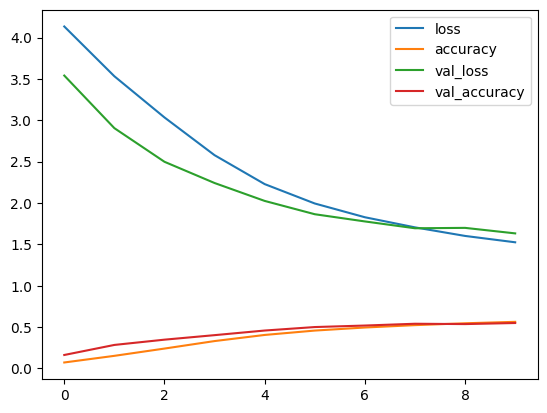

In [16]:
# Loss
plt.plot(r.history['loss'])

# Accuracy
plt.plot(r.history['sparse_categorical_accuracy'])

# Loss (validation)
plt.plot(r.history['val_loss'])

# Accuracy (validation)
plt.plot(r.history['val_sparse_categorical_accuracy'])

plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
plt.show()

We observe that accuracy increases over epochs, and loss decreases. This is a good sign, indicating that our model is learning well.

However, we also see that the accuracy increases less and less over epochs, and the loss decreases less and less. This is normal, as the more the model learns, the harder it is to improve its performance.

## Testing the model

### Performance evaluation

Now that our model is trained, we will evaluate its performance using the test dataset. We will use the `evaluate` function to evaluate the model on test images.

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset_tf_preprocessed)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.6268 - sparse_categorical_accuracy: 0.5560


With 10 epochs, we achieve an accuracy higher than **50%**. This is a good score, but it could obviously be improved by increasing the number of epochs and the size of the dataset.

### Interactive testing

To see how our model behaves on test images, we will create a `test_model` function that predicts the labels of a certain number of random images and displays the images with their true label as well as the predicted label.

In [18]:
def test_model(model, test_dataset, num_samples):
    """
    Uses the `model` parameter to predict `num_samples` labels
    from the `test_dataset`.
    Displays the images with their label and associated predictions.
    """

    # Randomly retrieve images
    indices = random.sample(range(len(test_dataset)), num_samples)
    sample_images = [test_dataset[i]["img"] for i in indices]
    sample_labels = [test_dataset[i]["fine_label"] for i in indices]

    # Preprocess retrieved images
    sample_images_preprocessed = [preprocess_image(img, label)[0].numpy() for img, label in zip(sample_images, sample_labels)]
    sample_images_preprocessed = np.array(sample_images_preprocessed)

    # Predict labels
    predictions = model.predict(sample_images_preprocessed)
    predicted_labels = np.argmax(predictions, axis=1)

    # Display results
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_images[i])
        true_label = fine_labels_dict[sample_labels[i]]
        predicted_label = fine_labels_dict[predicted_labels[i]]
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')

    plt.show()

Let's use the function to display and predict the labels of 10 images:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


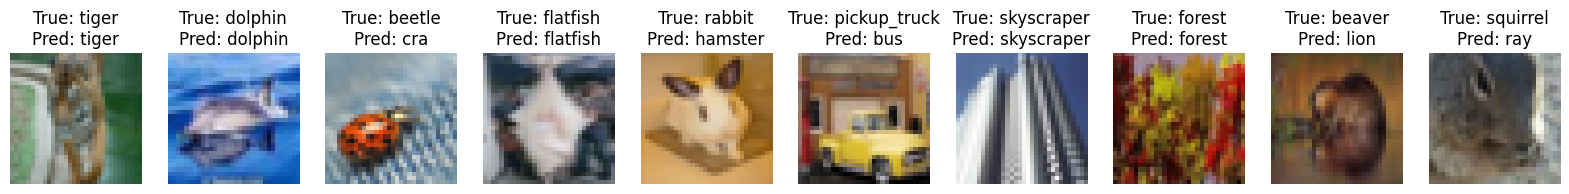

In [19]:
test_model(model, test_dataset, 10)

We observe that our model correctly predicts most images. This means that our model has learned well and is capable of generalizing to images it has never seen.

Moreover, we notice that when the model makes mistakes, it still predicts labels that are quite close to reality. It will correctly predict an animal but get the species wrong, for example. The same goes for plants, vehicles, etc. If we had used the dataset with `coarse labels`, the model would probably have been more accurate, as the classes are more general.

Some images are difficult to predict, even for a human. This is normal, as CIFAR-100 is a difficult dataset with low-resolution images and very similar classes.

## Saving the model

Sauvegardons le modèle pour pouvoir le réutiliser plus tard.

In [20]:
model.save('cifar100_model.keras')

## Loading the model

If you couldn't train the model, let's load the provided version and test it.

In [21]:
loaded_model = tf.keras.models.load_model('cifar100_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


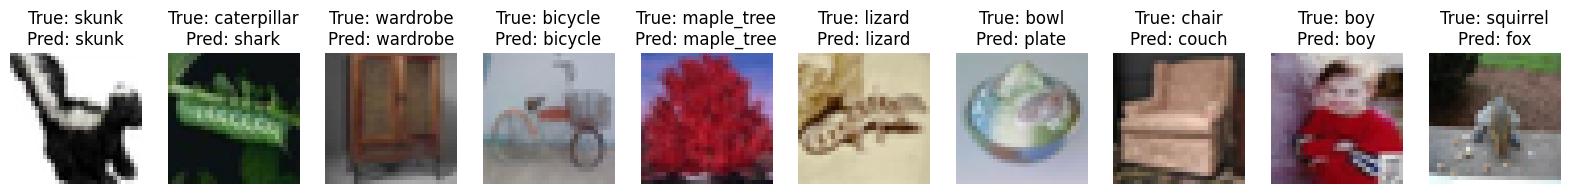

In [22]:
test_model(loaded_model, test_dataset, 10)

## Conclusion

My method for recognizing CIFAR-100 images, a CNN model, is advantageous because it allows for good accuracy with a **simple architecture**, not a lot of **data**, and a **reasonable** training time.

Obviously, this model is not perfect, and there are many ways to improve it. We could, for example:

- Use a more complex model (more layers, more neurons)
- Increase the number of epochs
- Increase the size of the dataset
- Experiment even more with the neural network architecture to find the best possible configuration

Nevertheless, I am very happy with this deep learning project. By going up to **50 epochs** on Google Colab, I was able to achieve over **70%** accuracy on the test dataset, which is a very good score for such a model. You can check the plot of the accuracy and loss with 50 epochs on the repo.

In comparison, deep learning models on [ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet) achieve accuracies of **90%** and more, but they are trained on many more higher-quality images with much more complex architectures (*2 billion* parameters for some models, compared to *4 million* for mine).

I am therefore very satisfied with this project, and I look forward to continuing to explore the world of deep learning and artificial intelligence.